In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [54]:
class FNN(tf.keras.Model):
    # Initialization
    def __init__(self, layer, activation):
        super(FNN, self).__init__()
        self.layer = layer
        # This loop creates a list of hidden layers. The loop iterates over layer (except the last element, which is the output layer)
        num_h = len(layer)
        self.branch_hidden = []
        for i in range(num_h-1):
            self.branch_hidden.append(tf.keras.layers.Dense(
                units=layer[i], activation=activation
            ))
        # The last layer (layer[-1]) is the output layer. It does not use an activation function, as this is typical for regression tasks or when applying the activation function later
        self.branch_out = tf.keras.layers.Dense(units=layer[-1])
    
    #Forward Passing
    def call(self, input):
        x = input
        L = len(self.layer)
        # A loop runs over all the hidden layers (L-1 times) and applies them sequentially. Each layer processes the data and passes the output to the next layer.
        for i in range(L-1):
            x = self.branch_hidden[i](x)
        return self.branch_out(x) # returning model's prediction


In [55]:
class Deepon(tf.keras.Model):
    def __init__(self, branch_layer, trunk_layer, activation):
        super(Deepon, self).__init__()
        self.branch = FNN(layer=branch_layer, activation=activation)
        self.trunk = FNN(layer=trunk_layer, activation=activation)

    def call(self, input):
        input_branch = input[0]
        input_trunk = input[1]
        output_branch = self.branch(input_branch)
        ouput_trunk = self.trunk (input_trunk)
        return tf.reduce_sum(tf.multiply(output_branch, ouput_trunk),-1)

In [57]:
def generate_data(num_samples=10000, num_t_points=20):

    A = np.random.uniform(0.5, 10, num_samples)
    w = np.random.uniform(1, 4, num_samples)
    t = np.linspace(0, 1, num_t_points)

    branch_input = np.zeros((num_samples, num_t_points))
    trunk_input = np.zeros((num_samples, 1))
    derivative_list = []

    trunk_time = np.linspace(0, 1, num_samples)

    for i in range(num_samples):
        for j in range(num_t_points):
            branch_input[i, j] = A[i]*np.sin(np.pi*w[i]*t[j])
        
        derivative_list.append(np.pi*A[i]*w[i]*np.cos(np.pi*w[i]*trunk_time[i]))
        trunk_input[i, 0] = trunk_time[i]


    derivative_list = np.array(derivative_list)

    X_train = (branch_input, trunk_input)
    y_train = derivative_list
    
    return (X_train, y_train)


In [58]:
X_train, y_train = generate_data()
branch_layer = [40, 40, 40, 40]
trunk_layer  = [40, 40, 40, 40]
activation = "tanh"
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
num_epochs = 2200
batch_size = 1000

print(X_train[0].shape)
print(X_train[1].shape)
print(y_train.shape)

(10000, 20)
(10000, 1)
(10000,)


In [59]:
model_deepon = Deepon(branch_layer=branch_layer, trunk_layer=trunk_layer, activation=activation)
model_deepon.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
model_deepon.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=2)

Epoch 1/2200
10/10 - 1s - 88ms/step - loss: 1216.7985
Epoch 2/2200
10/10 - 0s - 2ms/step - loss: 1185.0564
Epoch 3/2200
10/10 - 0s - 2ms/step - loss: 1171.1731
Epoch 4/2200
10/10 - 0s - 2ms/step - loss: 1157.2550
Epoch 5/2200
10/10 - 0s - 2ms/step - loss: 1139.9874
Epoch 6/2200
10/10 - 0s - 2ms/step - loss: 1128.4750
Epoch 7/2200
10/10 - 0s - 2ms/step - loss: 1124.0895
Epoch 8/2200
10/10 - 0s - 2ms/step - loss: 1121.4065
Epoch 9/2200
10/10 - 0s - 3ms/step - loss: 1119.1426
Epoch 10/2200
10/10 - 0s - 2ms/step - loss: 1116.3813
Epoch 11/2200
10/10 - 0s - 2ms/step - loss: 1114.1005
Epoch 12/2200
10/10 - 0s - 2ms/step - loss: 1112.5541
Epoch 13/2200
10/10 - 0s - 3ms/step - loss: 1112.7462
Epoch 14/2200
10/10 - 0s - 2ms/step - loss: 1111.2762
Epoch 15/2200
10/10 - 0s - 2ms/step - loss: 1110.3112
Epoch 16/2200
10/10 - 0s - 2ms/step - loss: 1110.8351
Epoch 17/2200
10/10 - 0s - 2ms/step - loss: 1109.4514
Epoch 18/2200
10/10 - 0s - 2ms/step - loss: 1108.9728
Epoch 19/2200
10/10 - 0s - 2ms/step 

In [78]:
num_samples = 1
num_t_points = 20

trunk_time_list = np.linspace(0, 1, num_t_points)
y_pred_list = []
y_test_list = []

for trunk_time in trunk_time_list:

    A = [0.79]
    w = [4]
    t = np.linspace(0, 1, num_t_points)

    branch_input = np.zeros((num_samples, num_t_points))
    trunk_input = np.zeros((num_samples, 1))
    derivative_list = []

    for i in range(num_samples):
        for j in range(num_t_points):
            branch_input[i, j] = A[i]*np.sin(np.pi*w[i]*t[j])
        
        derivative_list.append(np.pi*A[i]*w[i]*np.cos(np.pi*w[i]*trunk_time))
        trunk_input[i, 0] = trunk_time


    derivative_list = np.array(derivative_list)

    X_test = (branch_input, trunk_input)
    y_test = derivative_list

    y_pred = model_deepon.predict(X_test)
    t = X_test[1].reshape((-1))

    y_pred_list.append(y_pred)
    y_test_list.append(y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


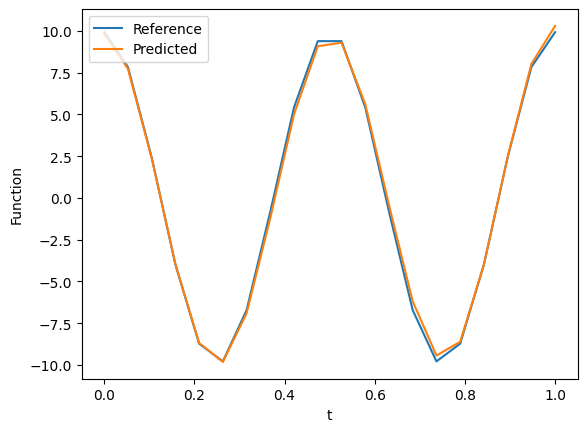

In [79]:
plt.plot(trunk_time_list, y_test_list, label="Reference")
plt.plot(trunk_time_list, y_pred_list, label="Predicted")

plt.legend(loc="upper left")

plt.ylabel("Function")
plt.xlabel("t")
plt.show()